In [1]:
# Notebook: NLTK Naive Bayes Classifier
# Author: Thomas Purk
# Date: 2025-03-31
# Reference: https://www.nltk.org/howto/classify.html
# Reference: https://en.wikipedia.org/wiki/Naive_Bayes_classifier
# Reference: https://www.udemy.com/certificate/UC-a9c3a1ee-f780-447f-8bdf-5a9c2afb8dd0/

In [2]:
!pip list | grep nltk

nltk                               3.9.1


# NLTK Naive Bayes Classifier

> Naive Bayes is a simple technique for constructing classifiers: models that assign class labels to problem instances, represented as vectors of feature values, where the class labels are drawn from some finite set. There is not a single algorithm for training such classifiers, but a family of algorithms based on a common principle: all naive Bayes classifiers assume that the value of a particular feature is independent of the value of any other feature, given the class variable. For example, a fruit may be considered to be an apple if it is red, round, and about 10 cm in diameter. A naive Bayes classifier considers each of these features to contribute independently to the probability that this fruit is an apple, regardless of any possible correlations between the color, roundness, and diameter features.

https://en.wikipedia.org/wiki/Naive_Bayes_classifier

> Classifiers label tokens with category labels (or class labels). Typically, labels are represented with strings (such as "health" or "sports". In NLTK, classifiers are defined using classes that implement the ClassifierI interface, which supports the following operations:

https://www.nltk.org/howto/classify.html


In [3]:
# Notebook Setup
import string

# Data, Science, & Math
import numpy as np
import pandas as pd
import random

# Visualization
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Add for better Jupyter Notebook compatibility
%matplotlib inline

# NLP
import nltk
from nltk.corpus import movie_reviews
from nltk.corpus import stopwords
from nltk.classify import NaiveBayesClassifier
from nltk.classify.util import accuracy

# Prevent Pandas and other warnings from displaying above outputcells, improve readability
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once') # See warnings one time#

In [4]:
# Load Data
nltk.download('movie_reviews')

# Validate
movie_reviews

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


<CategorizedPlaintextCorpusReader in '/root/nltk_data/corpora/movie_reviews'>

In [5]:
# Download stopwords if not already available
nltk.download('stopwords')

# Load English stopwords
stop_words = set(stopwords.words('english'))

# Validate
list(stop_words)[:10]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


["isn't", 'mightn', "i'm", "we'd", 'below', 'or', 'our', 'been', 'few', 'him']

In [6]:
# Investigate the Corpus
print(f'Categories: {movie_reviews.categories()}')
print(f'Field Ids (len): {len(movie_reviews.fileids())}')
print(f'First neg Field Id: {movie_reviews.fileids("neg")[0]}')
print(f'First pos Field Id: {movie_reviews.fileids("pos")[0]}')
#print(f'Citation: {movie_reviews.citation()}') # does not exist, error
#print(f'Categories: {movie_reviews.license()}')# does not exist, error


Categories: ['neg', 'pos']
Field Ids (len): 2000
First neg Field Id: neg/cv000_29416.txt
First pos Field Id: pos/cv000_29590.txt


In [7]:
# 2 example documents
print(f'First "neg" doc: {movie_reviews.words("neg/cv000_29416.txt")}')
print(f'First "pos" doc: {movie_reviews.words("pos/cv000_29590.txt")}')


First "neg" doc: ['plot', ':', 'two', 'teen', 'couples', 'go', 'to', ...]
First "pos" doc: ['films', 'adapted', 'from', 'comic', 'books', 'have', ...]


In [8]:
# Load all documents
documents = [(list(movie_reviews.words(fileid)), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

# Shuffle data to mix positive and negative examples
random.shuffle(documents)

print(f'Docs loaded : {len(documents)}')
print(f'Example Doc : {documents[0]}')

Docs loaded : 2000
Example Doc : (['"', 'first', 'rule', 'of', 'fight', 'club', 'is', ',', 'don', "'", 't', 'talk', 'about', 'fight', 'club', '.', '"', 'this', 'quote', 'deals', 'directly', 'with', 'my', 'opinion', 'of', 'this', 'film', ',', 'because', 'quite', 'frankly', ',', 'it', "'", 's', 'not', 'even', 'worth', 'mentioning', '.', 'director', 'david', 'fincher', '(', 'seven', ')', 'has', 'completely', 'gone', 'over', 'the', 'edge', '.', 'with', 'crude', 'humor', ',', 'an', 'intolerable', 'script', 'and', '2', 'hours', 'and', '19', 'minutes', 'of', 'pure', 'torture', ',', 'i', "'", 'm', 'surprised', 'i', 'didn', "'", 't', 'walk', 'out', '.', 'this', 'just', 'goes', 'to', 'show', 'that', 'hype', 'kills', '.', 'it', "'", 's', 'very', 'rare', 'that', 'a', 'film', 'so', 'hyped', 'up', 'as', '"', 'fight', 'club', '"', 'turns', 'out', 'to', 'be', 'noteworthy', ',', 'and', 'this', 'is', 'no', 'exception', '.', 'the', 'story', 'goes', 'like', 'this', '.', 'edward', 'norton', 'is', 'an', 'in

# Data Preparation

In [9]:
# Convert raw text into  features using the Bag-Of-Words (BOW) approach

def filter_words(words):
    ''' Remove words from the list based on criteria

    Parameters:
        words (list): The collection of words to consider.

    Returns:
        list: Filtered words
    '''
    return [
        word.lower() for word in words
        if word.isalpha()  # Remove punctuation
        and word.lower() not in stop_words  # Remove stopwords
    ]



# Extract all words in the dataset
all_words = filter_words(movie_reviews.words() )

# Get the frequency distribution of words
all_words_freq = nltk.FreqDist(all_words)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'film'),
  Text(1, 0, 'one'),
  Text(2, 0, 'movie'),
  Text(3, 0, 'like'),
  Text(4, 0, 'even'),
  Text(5, 0, 'good'),
  Text(6, 0, 'time'),
  Text(7, 0, 'story'),
  Text(8, 0, 'would'),
  Text(9, 0, 'much'),
  Text(10, 0, 'character'),
  Text(11, 0, 'also'),
  Text(12, 0, 'get'),
  Text(13, 0, 'two'),
  Text(14, 0, 'well'),
  Text(15, 0, 'characters'),
  Text(16, 0, 'first'),
  Text(17, 0, 'see'),
  Text(18, 0, 'way'),
  Text(19, 0, 'make')])

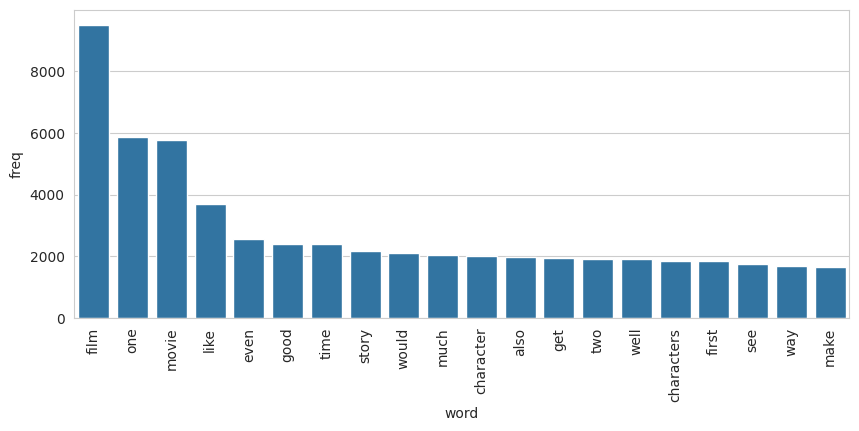

In [10]:
# Plot top words per frequence to demonstrate thedata
df_top_words = pd.DataFrame(
    data=all_words_freq.most_common(20),
    columns=['word','freq']
)

plt.figure(figsize=(10,4))
sns.barplot(
    data=df_top_words,
    x='word',
    y='freq'
)
plt.xticks(rotation=90)

In [11]:
# Select the top 4000 most common words to mark True as features
word_features = list(all_words_freq.keys())[:2000]

# Filter short words which could have less meaning than long words
#word_features = [w for w in word_features]

# Define feature extractor function
def extract_features(document):
    ''' Determines if a word in the document is a feature or not.

    Parameters:
        document (list): A list of words comprising the document.

    Returns:
        dict: A dictionary marking each word True or False
    '''
    # Convert list to set for faster lookup
    words = set(filter_words(document))
    # Create a dict marking each word as True if in the document, or False if not
    features = {word: (word in words) for word in word_features}
    return features

# Create feature sets
# NOTE: Each document in documents is a tuple (<word-list>,<'neg' of 'pos'>)
# The Feature Sets is a list of tuples
feature_sets = [(extract_features(review), category) for (review, category) in documents]

In [12]:
type(all_words_freq)

nltk.probability.FreqDist

## Train the Model

In [13]:
# Split the data into training (80%) and testing (20%) data
train_size = int(len(feature_sets) * 0.8)
train_data = feature_sets[:train_size] # slice begining to size, not inclusive
test_data = feature_sets[train_size:] # slice size to end

print(f'Training data size: {len(train_data)}')
print(f'Testing data size: {len(test_data)}')

Training data size: 1600
Testing data size: 400


In [14]:
# Train the NLTK Naive Bayes Classifier
classifier = NaiveBayesClassifier.train(train_data)



Classifier Labels: ['neg', 'pos']

Most Informative Features
                 frances = True              pos : neg    =      7.9 : 1.0
                  welles = True              neg : pos    =      7.5 : 1.0
                 stellan = True              pos : neg    =      7.2 : 1.0
                explores = True              pos : neg    =      6.8 : 1.0
                  turkey = True              neg : pos    =      6.5 : 1.0
              reflection = True              pos : neg    =      6.5 : 1.0
                  inject = True              neg : pos    =      6.0 : 1.0
              schumacher = True              neg : pos    =      6.0 : 1.0
                  poorly = True              neg : pos    =      5.9 : 1.0
                 singers = True              pos : neg    =      5.8 : 1.0


In [17]:
# Evaluate the model
test_acc = accuracy(classifier, test_data)


# Manual Evaluation
test_matches = []

for item in test_data:
    feature_set = item[0]
    result = classifier.classify(feature_set)
    test_matches.append(result == item[1])

manual_test_acc = sum(test_matches) / len(test_matches)

print(f'Classifier Labels: {classifier.labels()}')
print('')
# Show the most informative features
classifier.show_most_informative_features(10)
print('')
print(f'NLTK Accuracy: { test_acc* 100:.2f}%')
print('')
print(f'Manual Accuracy: { manual_test_acc* 100:.2f}%')


Classifier Labels: ['neg', 'pos']

Most Informative Features
                 frances = True              pos : neg    =      7.9 : 1.0
                  welles = True              neg : pos    =      7.5 : 1.0
                 stellan = True              pos : neg    =      7.2 : 1.0
                explores = True              pos : neg    =      6.8 : 1.0
                  turkey = True              neg : pos    =      6.5 : 1.0
              reflection = True              pos : neg    =      6.5 : 1.0
                  inject = True              neg : pos    =      6.0 : 1.0
              schumacher = True              neg : pos    =      6.0 : 1.0
                  poorly = True              neg : pos    =      5.9 : 1.0
                 singers = True              pos : neg    =      5.8 : 1.0

NLTK Accuracy: 79.00%

Manual Accuracy: 79.00%
